In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
def train_test_split(df, train_ratio, X, y, random = False, dtrain = False):
    """
    Argument
    df : DataFrame object
    train_ratio : float, in range(0,1)
    X : sequence data, such as list, tuple (Train Features)
    y : str
    random : boolean, you need "numpy" library cause we use np.random.permutation function.
    
    Return
    train : 학습시킬 Feature data
    train_idx : 지도학습의 Y value
    test : test 검증할 Feature data
    test_idx : test set의 Y value
    """
    train_size = int(len(df)*train_ratio)
    if random:
        shuffle_indicies = np.random.permutation(len(df))
        train_indicies = shuffle_indicies[:train_size]
        test_indicies = shuffle_indicies[train_size:]
    else:
        normal_indicies = np.arange(len(df))
        train_indicies = normal_indicies[:train_size]
        test_indicies = normal_indicies[train_size:]
    if dtrain:
        train = df.iloc[:train_size]
        train_idx = df.iloc[:train_size]
        test = df.iloc[train_size:]
        test_idx = df.iloc[train_size:]
    else:
        train = df.iloc[:train_size][X]
        train_idx = df.iloc[:train_size][y]
        test = df.iloc[train_size:][X]
        test_idx = df.iloc[train_size:][y]
    return train, train_idx, test, test_idx

In [3]:
kospi200 = pd.read_csv("./data/data.csv", encoding="cp949")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)

name_dict = { i : j for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }
code_dict = { j : i for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }

In [4]:
import pickle
with open('raw_data_20180824.pickle','rb') as handle:
    raw_data = pickle.load(handle)

In [5]:
raw_data[name_dict['삼성전자']].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,0.092131,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,0.084139,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,0.084743,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,0.083536,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,0.087004,46880000


In [6]:
party_df = pd.read_csv('party_df.csv')

In [7]:
party_df["종목코드"] = party_df["종목코드"].map('{:06d}'.format)

In [8]:
party_df.head()

,업종,영문코드,종목명,종목코드,시가총액,income
0,정보기술,SEC,삼성전자,005930,296893767375000,high
1,정보기술,SKH,SK하이닉스,000660,62826604099500,high
2,헬스케어,CTRN,셀트리온,068270,34044987664500,high
3,철강소재,POSCO,POSCO,005490,28815248967500,high
4,경기소비재,HMC,현대차,005380,28525804030500,high


In [9]:
del_list = []
for key, df in raw_data.items():
    if len(df) < 252*2:
        del_list.append(key)
for code in del_list:
    del raw_data[code]

In [10]:
[code_dict[i] for i in del_list]

['BGF리테일',
 'HDC현대산업개발',
 'SK케미칼',
 '넷마블',
 '두산밥캣',
 '삼성바이오로직스',
 '오리온',
 '현대중공업지주',
 '효성중공업']

In [245]:
import sys
mod = sys.modules[__name__]
for code in raw_data.keys():
    """
    X
    """
    raw_data[code]["pct_change"] = raw_data[code].Close.pct_change().shift(1)
    for i in range(3, 30):
        raw_data[code]["close_ma_{}".format(i)] = raw_data[code].Close.rolling(window = i).mean().shift(1)
        raw_data[code]["volume_ma_{}".format(i)] =  raw_data[code].Volume.rolling(window = i).mean().shift(1)
        #raw_data[code]["close_ewm_{}".format(i)] = raw_data[code].Close.ewm(span = i).mean()
        #raw_data[code]["volume_ewm_{}".format(i)] = raw_data[code].Volume.ewm(span = i).mean()
        if i in [7, 21, 30, 60, 90, 91, 100, 120]:
            raw_data[code]["his_vol_{}".format(i)] = raw_data[code]["pct_change"].fillna(0).rolling(window = i).std().shift(1)/(252**0.5)
    """
    Y
    """
    
    raw_data[code] = raw_data[code].assign(Y1 = raw_data[code].Close - raw_data[code].close_ma_7.shift(1))
    raw_data[code] = raw_data[code].assign(Y2 =
                                           raw_data[code]["pct_change"] - raw_data[code]["pct_change"].rolling(window = 7).mean().shift(1))
    raw_data[code] = raw_data[code].assign(Y3 = raw_data[code].Close.rolling(window=7).sum().pct_change())
    
    raw_data[code] = raw_data[code].assign(Y1 = np.where(raw_data[code].Y1>=0, 1, 0))
    raw_data[code] = raw_data[code].assign(Y2 = np.where(raw_data[code].Y2>=0, 1, 0))
    raw_data[code] = raw_data[code].assign(Y3 = np.where(raw_data[code].Y3>=0, 1, 0))
    """
    Drop NaN
    """
    raw_data[code] = raw_data[code].dropna(axis=0)

In [175]:
test = {}
for code in raw_data.keys():
    test[code] = raw_data[code][['Close', 'Y2']]
    test[code] = test[code].assign(change = (test[code]['Y2']-test[code]['Y2'].shift(1)).fillna(0))
    test[code] = test[code].assign(close_change = (test[code]['Close']-test[code]['Close'].shift(1)).fillna(0))
    test[code] = test[code].assign(return_price = np.where(test[code]['change']==0, 0, test[code]['close_change']))
    test[code] = test[code].assign(balance = test[code]['return_price'].cumsum())
    test[code] = test[code].assign(compare = test[code]['Close']-test[code]['Close'][0])

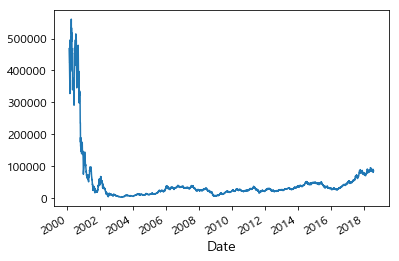

In [242]:
raw_data[name_dict['SK하이닉스']].Close.plot()

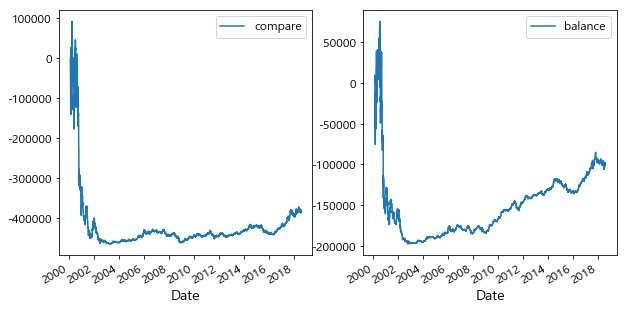

In [184]:
plt.figure(figsize=(10,5))
plt.subplot(121)
test[name_dict['SK하이닉스']].compare.plot()
plt.legend(fontsize=12)
plt.subplot(122)
test[name_dict['SK하이닉스']].balance.plot()
plt.legend(fontsize=12)

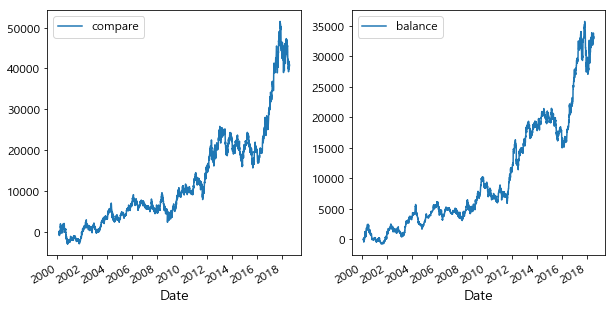

In [183]:
plt.figure(figsize=(10,5))
plt.subplot(121)
test[name_dict['삼성전자']].compare.plot()
plt.legend(fontsize=12)
plt.subplot(122)
test[name_dict['삼성전자']].balance.plot()
plt.legend(fontsize=12)

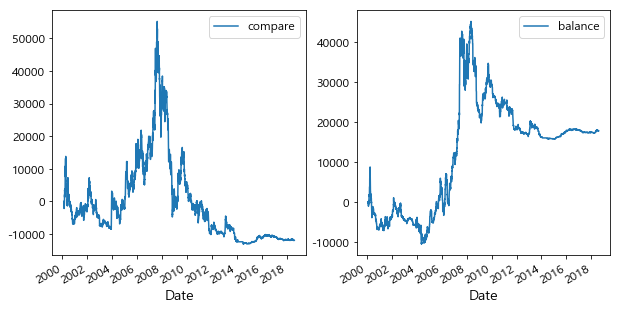

In [182]:
plt.figure(figsize=(10,5))
plt.subplot(121)
test[name_dict['동양']].compare.plot()
plt.legend(fontsize=12)
plt.subplot(122)
test[name_dict['동양']].balance.plot()
plt.legend(fontsize=12)

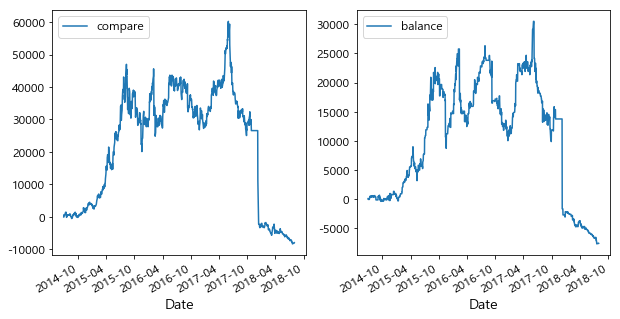

In [181]:
plt.figure(figsize=(10,5))
plt.subplot(121)
test[name_dict['BGF']].compare.plot()
plt.legend(fontsize=12)
plt.subplot(122)
test[name_dict['BGF']].balance.plot()
plt.legend(fontsize=12)

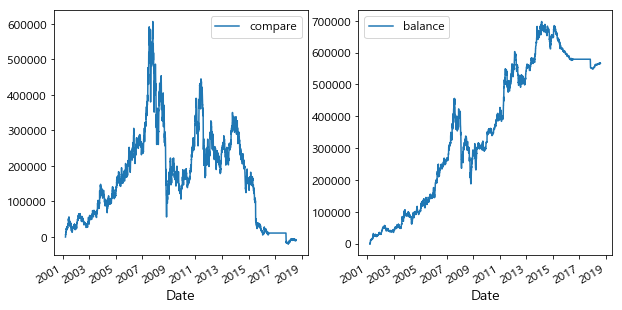

In [180]:
plt.figure(figsize=(10,5))
plt.subplot(121)
test[name_dict['대우조선해양']].compare.plot()
plt.legend(fontsize=12)
plt.subplot(122)
test[name_dict['대우조선해양']].balance.plot()
plt.legend(fontsize=12)

In [246]:
def modelfit(alg, dtrain, predictors, target, useTrainCV = True, 
             cv_folds = 5, early_stopping_rounds = 50, top = 10, 
             figure = True, model_report = True):
    
    start = time.time()
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    if model_report:
        #Print model report:
        print("Model Report")
        print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
        print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    imp_fear_name = pd.Series(predictors)[alg.feature_importances_ > 0.01]
    imp_fear_name.index = range(len(imp_fear_name))
    imp_fear = pd.concat((imp_fear_name, 
               pd.Series(alg.feature_importances_[alg.feature_importances_ > 0.01])),axis=1).sort_values(by=1,ascending=True)
    imp_fear.index = range(len(imp_fear))
    imp_fear.columns = ["feature_name", "feature_importance"]
#     {i:j for i,j in zip(imp_fear.index, imp_fear["feature_name"])}
    if figure:
        if top:
            imp_fear.iloc[-top:].plot(y='feature_importance', x='feature_name', kind='barh', legend=False, figsize=(8,5))
        else:
            imp_fear.plot(y='feature_importance', x='feature_name', kind='barh', legend=False, figsize=(8,5))
    
#     feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances', figsize=(200,5))
#     plt.ylabel('Feature Importance Score')
    
    elapse = time.time() - start
    print("elapse time : {} sec".format(round(elapse,2)))
    
    return alg, imp_fear, elapse

In [13]:
import xgboost as xgb

In [14]:
from xgboost.sklearn import XGBClassifier
#from sklearn.model_selection import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

xgb_clf = XGBClassifier(random_state=42)

In [247]:
alg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
top10 = ['삼성전자', 'SK하이닉스', '셀트리온', 'POSCO', 
         '현대차', 'LG화학', 'NAVER', '삼성물산', 
         '현대모비스']
predictors = [x for x in df.columns if x not in ['Y1','Y2','Y3']]
target = "Y2"

In [248]:
target

'Y2'

In [19]:
import time
from sklearn import metrics

In [249]:
data = {}
for code in raw_data.keys():
    data[code] = raw_data[code].loc['2012-01-01':]

In [250]:
train = {}
train_y = {}
test = {}
test_y = {}
for code, df in data.items():
    X_train, y_train, X_test, y_test = train_test_split(df, 0.8, predictors, target, dtrain=True)
    train[code] = X_train
    train_y[code] = y_train
    test[code] = X_test
    test_y[code] = y_test

Model Report
Accuracy : 0.9985
AUC Score (Train): 1.000000
elapse time : 1.94 sec


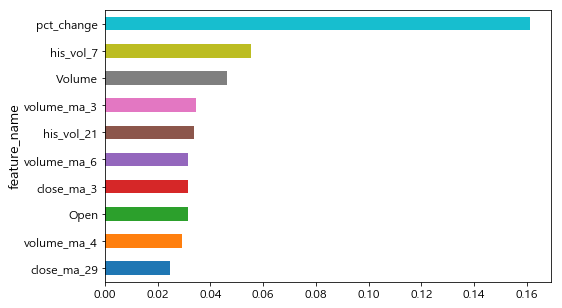

In [251]:
model, fear_importance, elapse = modelfit(alg, train["005930"], predictors, target, cv_folds=5, early_stopping_rounds=5)

In [252]:
model, fear_importance, elapse = modelfit(alg, train["005930"], predictors, target, cv_folds=5, early_stopping_rounds=5, 
                                  figure=False, model_report=False)

elapse time : 1.84 sec


In [253]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

total_time = 0
test_result = {}
fi_dict = {}
for i in raw_data.keys():
    model, fear_importance, elapse = modelfit(alg, train[i], predictors, target, 
                                              cv_folds=5, early_stopping_rounds=20,
                                              figure=False, model_report=False)
    start = time.time()
    pred = model.predict(test[i][predictors])
    # Calculating Score
    test_result[i] = np.array([
        metrics.accuracy_score(pred, test[i][target]),
        metrics.f1_score(pred, test[i][target]),
        metrics.precision_score(pred, test[i][target]),
        metrics.recall_score(pred, test[i][target]),
        metrics.roc_auc_score(pred, test[i][target])
    ])
    fi_dict[i] = {feature:value for feature,value in fear_importance.iloc[-10:].values}
    #print("test accuracy {} : {}".format(code_dict[i], accuracy[i]))
    total_time += elapse + time.time() - start
print("\ntotal time : {} minute".format(round(total_time / 60,2)))

result = pd.DataFrame(test_result, index = score_li).T

elapse time : 1.9 sec
elapse time : 1.3 sec
elapse time : 1.92 sec
elapse time : 1.73 sec
elapse time : 1.72 sec
elapse time : 1.7 sec
elapse time : 1.7 sec
elapse time : 1.7 sec
elapse time : 1.75 sec
elapse time : 1.91 sec
elapse time : 1.71 sec
elapse time : 1.72 sec
elapse time : 1.71 sec
elapse time : 1.67 sec
elapse time : 1.72 sec
elapse time : 1.82 sec
elapse time : 1.75 sec
elapse time : 1.69 sec
elapse time : 1.71 sec
elapse time : 1.79 sec
elapse time : 1.81 sec
elapse time : 1.68 sec
elapse time : 1.68 sec
elapse time : 1.77 sec
elapse time : 1.72 sec
elapse time : 1.75 sec
elapse time : 1.7 sec
elapse time : 1.71 sec
elapse time : 1.68 sec
elapse time : 1.6 sec
elapse time : 0.62 sec
elapse time : 0.85 sec
elapse time : 0.83 sec
elapse time : 0.89 sec
elapse time : 0.75 sec
elapse time : 0.8 sec
elapse time : 0.8 sec
elapse time : 0.75 sec
elapse time : 0.75 sec
elapse time : 0.8 sec
elapse time : 0.74 sec
elapse time : 0.74 sec
elapse time : 0.77 sec
elapse time : 0.77 se

In [254]:
score_li = ['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score']

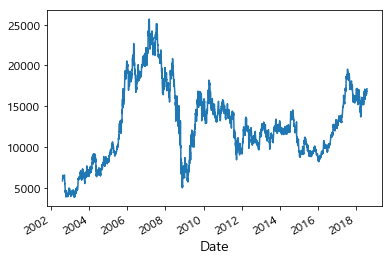

In [223]:
raw_data['000030'].Close.plot()

In [224]:
code_dict['000030']

'우리은행'

In [255]:
result.apply(np.mean)

accuracy_score     0.876270
f1_score           0.871108
precision_score    0.861949
recall_score       0.885164
roc_auc_score      0.879649
dtype: float64

In [256]:
party_df.head()

,업종,영문코드,종목명,종목코드,시가총액,income
0,정보기술,SEC,삼성전자,005930,296893767375000,high
1,정보기술,SKH,SK하이닉스,000660,62826604099500,high
2,헬스케어,CTRN,셀트리온,068270,34044987664500,high
3,철강소재,POSCO,POSCO,005490,28815248967500,high
4,경기소비재,HMC,현대차,005380,28525804030500,high


In [257]:
result['income'] = np.NaN
result['업종'] = np.NaN
for i in result.index:
    result.loc[i, 'income'] = party_df[party_df['종목코드'] == i]['income'].values[0]
    result.loc[i, '업종'] = party_df[party_df['종목코드'] == i]['업종'].values[0]

In [258]:
result.describe()

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
count,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.876270,0.871108,0.861949,0.885164,0.879649
std,0.028807,0.031483,0.060504,0.044232,0.026927
min,0.698980,0.697436,0.586207,0.726744,0.725252
25%,0.861111,0.856250,0.833333,0.854430,0.865326
50%,0.882716,0.875000,0.869281,0.887574,0.883908
75%,0.895062,0.892617,0.900000,0.916667,0.898626
max,0.932099,0.934211,0.976048,0.984252,0.931545


In [259]:
for income in result.income.unique():
    print(income)
    print(result.groupby('income').get_group(income).describe(), '\n')

high
       accuracy_score   f1_score  precision_score  recall_score  roc_auc_score
count       30.000000  30.000000        30.000000     30.000000      30.000000
mean         0.880804   0.873363         0.842269      0.909818       0.885094
std          0.016595   0.019910         0.046568      0.030339       0.015354
min          0.839506   0.815603         0.723270      0.837989       0.846210
25%          0.873655   0.868757         0.814691      0.894327       0.878753
50%          0.884259   0.875462         0.848947      0.912916       0.886957
75%          0.891204   0.882465         0.863517      0.930489       0.895241
max          0.907407   0.908537         0.925926      0.961240       0.909398 

low
       accuracy_score   f1_score  precision_score  recall_score  roc_auc_score
count       49.000000  49.000000        49.000000     49.000000      49.000000
mean         0.875055   0.868907         0.853212      0.890582       0.879099
std          0.036794   0.038862         

In [260]:
for income in result['업종'].unique():
    print(income)
    print(result.groupby('업종').get_group(income).describe(), '\n')

금융
       accuracy_score   f1_score  precision_score  recall_score  roc_auc_score
count       17.000000  17.000000        17.000000     17.000000      17.000000
mean         0.872186   0.864759         0.842081      0.894556       0.876773
std          0.027865   0.032285         0.055880      0.059186       0.026158
min          0.796296   0.791139         0.707006      0.726744       0.800872
25%          0.854938   0.850932         0.827381      0.864516       0.866778
50%          0.876543   0.874598         0.858974      0.917241       0.880000
75%          0.891975   0.882943         0.871951      0.931624       0.895351
max          0.910494   0.908517         0.920245      0.973684       0.911262 

생활소비재
       accuracy_score   f1_score  precision_score  recall_score  roc_auc_score
count       35.000000  35.000000        35.000000     35.000000      35.000000
mean         0.868637   0.862297         0.849481      0.881873       0.872992
std          0.039891   0.042074         

In [261]:
predictors = pd.DataFrame(fi_dict).T.notnull().sum().sort_values(ascending=False).index[:5].tolist()
targets = 'Y2'

alg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [262]:
predictors

['pct_change', 'his_vol_7', 'his_vol_21', 'Volume', 'Open']

In [263]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

total_time = 0
test_result = {}
fi_dict = {}
for i in raw_data.keys():
    model, fear_importance, elapse = modelfit(alg, train[i], predictors, target, 
                                              cv_folds=5, early_stopping_rounds=20,
                                              figure=False, model_report=False)
    start = time.time()
    pred = model.predict(test[i][predictors])
    # Calculating Score
    test_result[i] = np.array([
        metrics.accuracy_score(pred, test[i][target]),
        metrics.f1_score(pred, test[i][target]),
        metrics.precision_score(pred, test[i][target]),
        metrics.recall_score(pred, test[i][target]),
        metrics.roc_auc_score(pred, test[i][target])
    ])
    #fi_dict[i] = {feature:value for feature,value in fear_importance.iloc[-10:].values}
    #print("test accuracy {} : {}".format(code_dict[i], accuracy[i]))
    total_time += elapse + time.time() - start
print("\ntotal time : {} minute".format(round(total_time / 60,2)))

result = pd.DataFrame(test_result, index = score_li).T

elapse time : 0.7 sec
elapse time : 0.45 sec
elapse time : 0.52 sec
elapse time : 0.39 sec
elapse time : 0.43 sec
elapse time : 0.35 sec
elapse time : 0.35 sec
elapse time : 0.42 sec
elapse time : 0.34 sec
elapse time : 0.35 sec
elapse time : 0.33 sec
elapse time : 0.36 sec
elapse time : 0.34 sec
elapse time : 0.34 sec
elapse time : 0.35 sec
elapse time : 0.38 sec
elapse time : 0.33 sec
elapse time : 0.33 sec
elapse time : 0.33 sec
elapse time : 0.33 sec
elapse time : 0.34 sec
elapse time : 0.33 sec
elapse time : 0.33 sec
elapse time : 0.35 sec
elapse time : 0.34 sec
elapse time : 0.33 sec
elapse time : 0.33 sec
elapse time : 0.34 sec
elapse time : 0.32 sec
elapse time : 0.33 sec
elapse time : 0.25 sec
elapse time : 0.33 sec
elapse time : 0.33 sec
elapse time : 0.33 sec
elapse time : 0.32 sec
elapse time : 0.33 sec
elapse time : 0.35 sec
elapse time : 0.33 sec
elapse time : 0.33 sec
elapse time : 0.34 sec
elapse time : 0.35 sec
elapse time : 0.35 sec
elapse time : 0.33 sec
elapse time 

In [264]:
result['income'] = np.NaN
result['업종'] = np.NaN
for i in result.index:
    result.loc[i, 'income'] = party_df[party_df['종목코드'] == i]['income'].values[0]
    result.loc[i, '업종'] = party_df[party_df['종목코드'] == i]['업종'].values[0]

In [265]:
result.describe()

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
count,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.863834,0.857158,0.843037,0.876806,0.867663
std,0.030262,0.033660,0.065427,0.042256,0.028726
min,0.698980,0.691099,0.568966,0.755556,0.725146
25%,0.854938,0.843972,0.805195,0.847826,0.856985
50%,0.867284,0.861538,0.848101,0.877301,0.871035
75%,0.879630,0.875776,0.884956,0.910448,0.884496
max,0.922840,0.937634,0.981982,0.965517,0.925215


In [266]:
result.income.value_counts()

low             49
middle          49
lower middle    43
high            30
upper middle    22
Name: income, dtype: int64

In [267]:
result['업종'].value_counts()

경기소비재    38
생활소비재    35
에너지화학    24
금융       17
헬스케어     17
정보기술     15
산업재      15
건설       13
철강소재     10
중공업       9
Name: 업종, dtype: int64

In [268]:
for income in result.income.unique():
    print(income)
    print(result.groupby('income').get_group(income).describe(), '\n')

high
       accuracy_score   f1_score  precision_score  recall_score  roc_auc_score
count       30.000000  30.000000        30.000000     30.000000      30.000000
mean         0.864030   0.854350         0.816809      0.898398       0.869018
std          0.018202   0.021372         0.046747      0.029614       0.017316
min          0.820988   0.804054         0.734568      0.813725       0.830872
25%          0.858025   0.841694         0.786631      0.882792       0.867250
50%          0.870370   0.859498         0.816319      0.896678       0.873039
75%          0.875772   0.866879         0.847859      0.921392       0.878708
max          0.885802   0.893372         0.945122      0.945736       0.891582 

low
       accuracy_score   f1_score  precision_score  recall_score  roc_auc_score
count       49.000000  49.000000        49.000000     49.000000      49.000000
mean         0.857658   0.848789         0.826271      0.879674       0.863067
std          0.038864   0.043387         

In [269]:
for income in result['업종'].unique():
    print(income)
    print(result.groupby('업종').get_group(income).describe(), '\n')

금융
       accuracy_score   f1_score  precision_score  recall_score  roc_auc_score
count       17.000000  17.000000        17.000000     17.000000      17.000000
mean         0.860748   0.851594         0.821904      0.887005       0.864736
std          0.018418   0.023218         0.049552      0.036783       0.018581
min          0.824074   0.795699         0.713376      0.836478       0.830233
25%          0.851852   0.844595         0.785276      0.860465       0.855743
50%          0.864198   0.858108         0.831081      0.885135       0.869754
75%          0.873457   0.865031         0.850932      0.917197       0.874586
max          0.885802   0.886154         0.892617      0.965517       0.894853 

생활소비재
       accuracy_score   f1_score  precision_score  recall_score  roc_auc_score
count       35.000000  35.000000        35.000000     35.000000      35.000000
mean         0.857498   0.849388         0.829684      0.875419       0.861459
std          0.037946   0.040208         